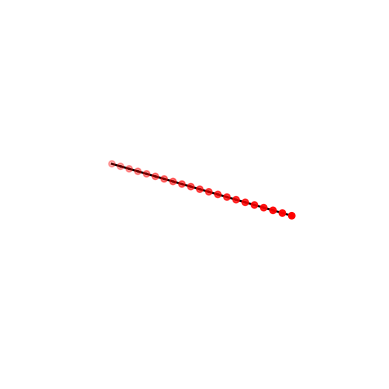

In [1]:
import numpy as np

import dismech

geom = dismech.GeomParams(rod_r0=0.001,
                          shell_h=0)

material = dismech.Material(density=1200,
                            youngs_rod=2e6,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

static_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('rft', ct=0.01, cn=0.1)  

geo = dismech.Geometry.from_txt('../tests/resources/rod_cantilever/horizontal_rod_n21.txt')

robot = dismech.SoftRobot(geom, material, geo, static_2d_sim, env)

In [2]:
stepper = dismech.ImplicitEulerTimeStepper(robot)

In [3]:
import numpy as np

def actuate_snake(robot, t):
    # --- Parameters you can tune ---
    amplitude = 0.2            # Max strain applied to each bend
    frequency = 1            # Oscillation frequency in Hz
    spatial_wavelength = 1.0   # Wavelength along the body in normalized units
    phase_offset = np.pi / 2   # Phase offset between vertical and tangential components

    # --- Compute strain pattern ---
    n_bends = robot.bend_springs.inc_strain.shape[0]
    s = np.linspace(0, 1, n_bends)  # Normalized position along body

    # Traveling sinusoidal waves for both vertical and tangential bending
    omega = 2 * np.pi * frequency
    k = 2 * np.pi / spatial_wavelength

    vertical_wave = amplitude * np.sin(omega * t + k * s)
    tangential_wave = amplitude * np.sin(omega * t + k * s + phase_offset)

    # Update robot bending strain (shape [n_bends, 2])
    #robot.bend_springs.inc_strain[:, 0] = vertical_wave     # normal bending
    robot.bend_springs.inc_strain[:, 1] = tangential_wave   # tangential bending

    return robot



robot0 = robot

stepper.before_step = actuate_snake
robots, t_arr, f_norms = stepper.simulate()
robots = [robot0] + robots # stack robot0 with the robots

qs = np.stack([robot.state.q for robot in robots])
t_arr = np.array([0, *t_arr])

iter: 1, error: 0.026
iter: 2, error: 1.221
iter: 3, error: 0.004
iter: 4, error: 0.004
current_time:  0.01
iter: 1, error: 0.003
iter: 2, error: 0.063
iter: 3, error: 0.000
current_time:  0.02
iter: 1, error: 0.002
iter: 2, error: 0.127
iter: 3, error: 0.000
current_time:  0.03
iter: 1, error: 0.002
iter: 2, error: 0.135
iter: 3, error: 0.000
current_time:  0.04
iter: 1, error: 0.001
iter: 2, error: 0.078
iter: 3, error: 0.000
current_time:  0.05
iter: 1, error: 0.001
iter: 2, error: 0.043
current_time:  0.060000000000000005
iter: 1, error: 0.001
iter: 2, error: 0.025
current_time:  0.07
iter: 1, error: 0.001
iter: 2, error: 0.013
current_time:  0.08
iter: 1, error: 0.001
iter: 2, error: 0.008
current_time:  0.09
iter: 1, error: 0.001
iter: 2, error: 0.010
current_time:  0.09999999999999999
iter: 1, error: 0.001
iter: 2, error: 0.013
current_time:  0.10999999999999999
iter: 1, error: 0.001
iter: 2, error: 0.014
current_time:  0.11999999999999998
iter: 1, error: 0.001
iter: 2, error: 0

In [4]:

print(len(robots), len(t_arr), qs.shape)

102 102 (102, 83)


In [5]:
# t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Snake')

fig = dismech.get_interactive_animation_plotly(robot, t_arr, qs, options)
fig.show()

In [6]:
from dismech.logging import logDataForRendering
t=t_arr[::1]
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), robot.sim_params.static_sim, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData.js', shell_js='shellData.js',
                          rod_radius=0.06, scaleFactor=10)

(102, 84) (102, 1) (102, 83)
(0,)
0


/home/radha/Desktop/PhD/dismech-python/dismech-python/src/dismech/logging.py:100: UserWarning:

loadtxt: input contained no data: "rawDataShell.txt"



In [7]:
import numpy as np

# 1) Extract κ_ref(t) from the teacher rollout
def extract_kappa_traj_from_robots(robots, stepper):
    be = stepper.elastic_energies['bend']     # your BendEnergy
    kappas = []
    for rb in robots:
        # BendEnergy.get_strain expects RobotState
        kappa = be.get_strain(rb.state)       # shape (Nb,2)
        kappas.append(kappa.astype(np.float64))
    kappas = np.stack(kappas, axis=0)         # (T, Nb, 2)
    return kappas

# Example:
# teacher_robots = stepper.simulate(robot_teacher)
# kappa_traj = extract_kappa_traj_from_robots(teacher_robots, stepper_teacher)
# ref_times = np.arange(kappa_traj.shape[0]) * stepper_teacher.sim_params.dt
kappa_traj = extract_kappa_traj_from_robots(robots, stepper)
ref_times = np.arange(kappa_traj.shape[0]) * robot.sim_params.dt

# 2) Save κ_ref(t) and ref_times to file for later use
np.savez('snake_kappa_ref.npz', kappa_traj=kappa_traj, ref_times=ref_times)


60


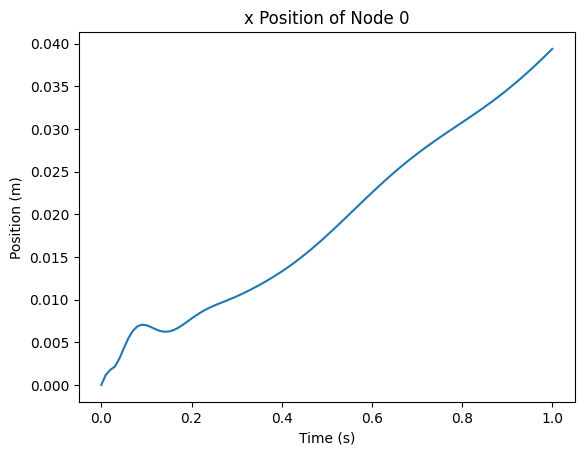

In [8]:
import matplotlib.pyplot as plt
print(robot.end_node_dof_index-3)
plt.title("x Position of Node 0")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
# plt.plot(t_arr, qs[:, robot.end_node_dof_index-3])  # x coordinate of the end node
plt.plot(t_arr, qs[:, 0]) #--- IGNORE ---
plt.show()

# save the trajectory of the first node x coordinate
np.savetxt("snake_node0_x_trajectory.txt", qs[:, 0])
np.savetxt("snake_node0_y_trajectory.txt", qs[:, 1])

In [9]:
# save DOF vector at all times in .npz
np.savez("snake_dof_trajectory.npz", qs=qs[:, 0:robot.end_node_dof_index])

In [10]:
# save end node x trajectory
np.savetxt("snake_node_last_x_trajectory.txt", qs[:, robot.end_node_dof_index-3])

In [11]:
from dismech.logging import logDataForRendering
t=t_arr[::1] # sampled time_array
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), robot.sim_params.static_sim, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData_snake_ref.js', shell_js='shellData.js',
                          rod_radius=0.06, scaleFactor=10)

(102, 84) (102, 1) (102, 83)
(0,)
0
